# Titanic Project

Discription:
* Clean Data
* Exploretory Data Analysis
* Feature Engineering
* Build Classifier models to predict which passengers survived

In [190]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [191]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_train = train.copy()
df_test = test.copy()

##  Data Cleaning

In [192]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Potentially not useful columns: PassengerId, Ticket, Cabin, Embarked


In [193]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From this summary we can see that some of the features have missing values. We can also see that the Fare feature potentially shows some outliers. 

In [194]:
#missing values
total = df_train.isnull().sum().sort_values(ascending = False)
percent = df_train.isnull().sum()/df_train.isnull().count().sort_values(ascending = False)
missing_values = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])
missing_values

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [195]:
total = df_test.isnull().sum().sort_values(ascending = False)
total

Cabin          327
Age             86
Fare             1
Embarked         0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

I first deal with missing values in Embarked

In [196]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


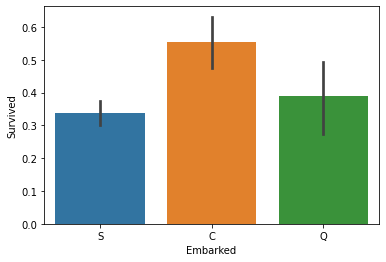

In [197]:
df_train['Embarked'].mode()
sns.barplot(df_train['Embarked'],df_train['Survived'])

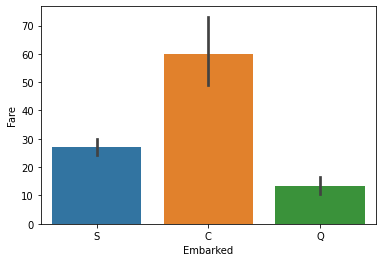

In [198]:
sns.barplot(df_train['Embarked'],df_train['Fare'])

Given the fact the passengers paid 80 and survived it makes most sense to fill with 'C'

In [199]:
df_train['Embarked'].fillna('C',inplace = True)

For the missing value in the Fare feature on the test set we will use the mean of the Pclass.

In [200]:
df_test.groupby('Pclass')['Fare'].mean()

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [201]:
df_test['Fare'].fillna(12.4596,inplace = True)

For filling in the Age we will use the passenger's names to determine the age.

In [202]:
df_train['Title'] = 0
for i in df_train:
    df_train['Title'] = df_train['Name'].str.extract('([A-Za-z]+)\.',expand = False)
#apply on test set as well
df_test['Title'] = 0
for i in df_test:
    df_test['Title'] = df_test['Name'].str.extract('([A-Za-z]+)\.',expand = False)   

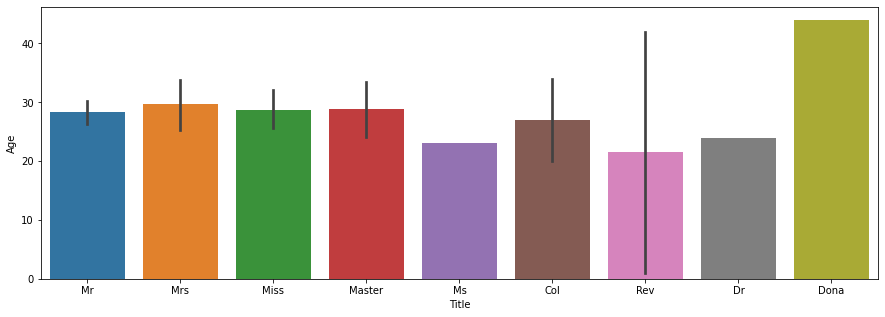

In [203]:
plt.figure(figsize = (15,5))
sns.barplot(df_test['Title'],df_train['Age'])

In [204]:
df_test.groupby('Title')['Age'].count()

Title
Col         2
Dona        1
Dr          1
Master     17
Miss       64
Mr        183
Mrs        62
Ms          0
Rev         2
Name: Age, dtype: int64

In [205]:
train_means = df_train.groupby('Title')['Age'].mean()
test_means = df_test.groupby('Title')['Age'].mean()
test_means

Title
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Ms              NaN
Rev       35.500000
Name: Age, dtype: float64

In [206]:
#Transform to dictionary
train_means_map = train_means.to_dict()
test_means_map = test_means.to_dict()

In [207]:
ind_nan_age = df_train.loc[np.isnan(df_train['Age'])].index
df_train.loc[ind_nan_age,'Age'] = df_train['Title'].loc[ind_nan_age].map(train_means_map)
idx_nan_age = df_test.loc[np.isnan(df_test['Age'])].index
df_test.loc[idx_nan_age, 'Age'] = df_test['Title'].loc[idx_nan_age].map(test_means_map)

In [208]:
df_test[df_test['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q,Ms


In [209]:
df_test['Age'].fillna(25,inplace = True)

## Exploratory  Data Analysis

Next I will look at the relationship the features have with the dependent variable.

#### Pclass

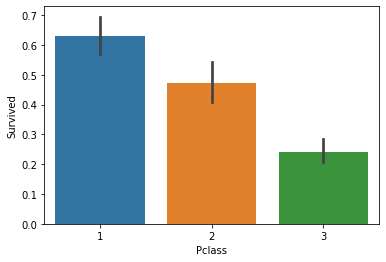

In [210]:
sns.barplot(df_train['Pclass'],df_train['Survived'])

We can see that the class you are in has an impact on your survival rate.

#### Fare

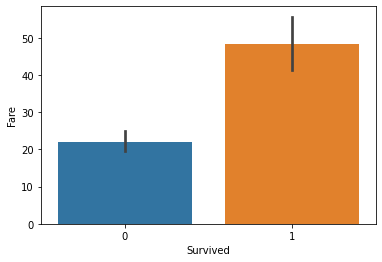

In [211]:
sns.barplot(df_train['Survived'],df_train['Fare'])

We can see that higher fare resulted in higher chance of surviving

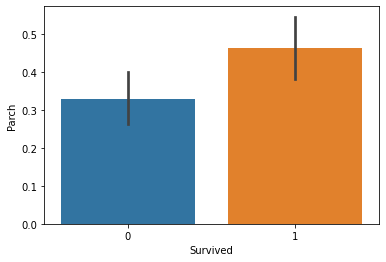

In [212]:
sns.barplot(df_train['Survived'],df_train['Parch'])

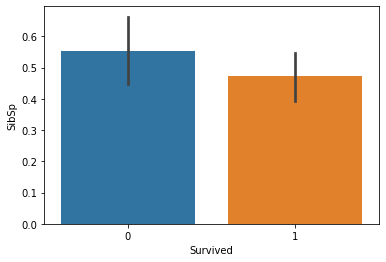

In [213]:
sns.barplot(df_train['Survived'],df_train['SibSp'])

Doesn't look like these features are to insightful. I will do some feature engineering later on with these features to see if can extract any useful information.

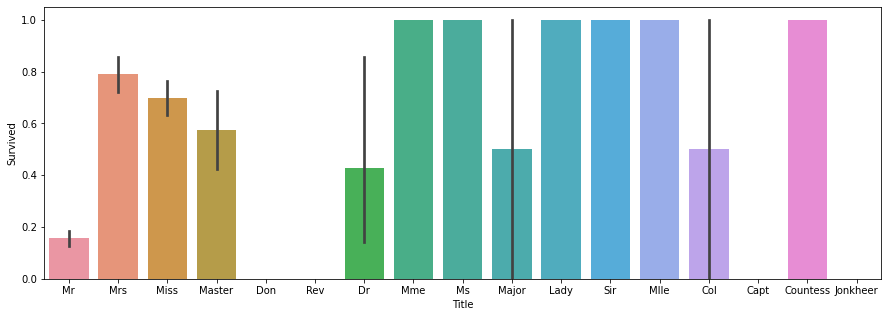

In [214]:
plt.figure(figsize= (15,5))
sns.barplot(df_train['Title'],df_train['Survived'])

In [215]:
df_train.groupby('Title')['PassengerId'].count()

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: PassengerId, dtype: int64

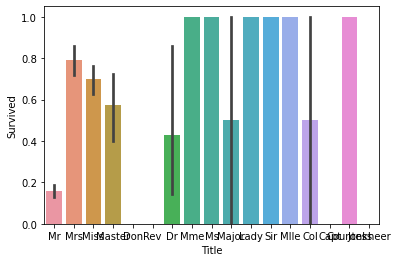

In [216]:
sns.barplot(df_train['Title'],df_train['Survived'])

We can see more clearly women and children had the highiest rate of survival

In [217]:
# change Sex feature to numerical to look at correlation 
df_train['Sex'] = df_train['Sex'].apply(lambda x: 0 if x == 'female' else 1)
df_test['Sex'] = df_test['Sex'].apply(lambda x: 0 if x == 'female' else 1)

In [218]:
corr = df_train.corr()
table = corr['Survived'].sort_values(ascending = False)
table.to_frame()

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
PassengerId,-0.005007
SibSp,-0.035322
Age,-0.089135
Pclass,-0.338481
Sex,-0.543351


This gives us another way of viewing the important features.

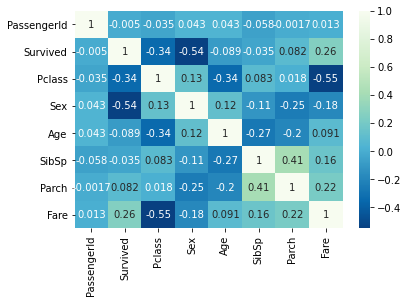

In [219]:
sns.heatmap(corr,cmap = 'GnBu_r',linecolor = 'white',annot = True)

Takeaways:
* Sex,Fare,and Pclass features have the most influence on the Survival feature by far.
    

### Outlier Detection

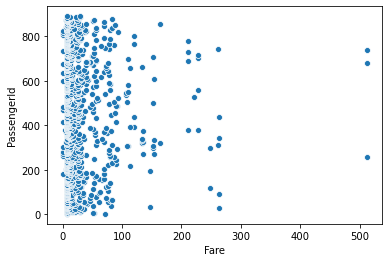

In [220]:
sns.scatterplot(x = df_train['Fare'],y = df_train['PassengerId'])

It looks like there are 3 obvious outliers that should be removed

In [221]:
df_train['Fare'].sort_values(ascending = False).head(4)

679    512.3292
258    512.3292
737    512.3292
341    263.0000
Name: Fare, dtype: float64

In [222]:
df_train.drop(df_train.index[[679,258,737]],inplace = True)

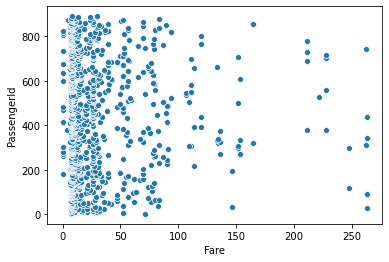

In [223]:
sns.scatterplot(x = df_train['Fare'],y = df_train['PassengerId'])

## Feature Engineering

In [224]:
# combine data first
y = df_train['Survived'].reset_index(drop=True)
all_data = pd.concat([df_train,df_test]).reset_index(drop=True)
all_data.drop(['Survived'],axis = 1, inplace = True)

In [225]:
all_data['fam_size'] = all_data['Parch'] + all_data['SibSp']

Lets see if this new feature makes sense

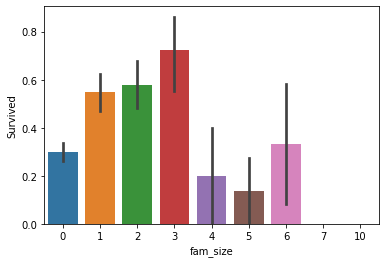

In [226]:
sns.barplot(all_data['fam_size'],y)

There is no obvious trend so instead we will create a new feature based on this one.

In [227]:
all_data['is_alone'] = [1 if i < 1 else 0 for i in all_data.fam_size]

At first glance the Cabin feature looks dropable but I believe we can create a feature that can be usefull.

In [228]:
all_data['has_cabin'] = all_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [229]:
#We will make the titles more concise since some of the titles only appear a couple of times
all_data['Title'] = [i.replace('Dona','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Ms','Miss') for i in all_data.Title]
all_data['Title'] = [i.replace('Lady','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Mlle','Miss') for i in all_data.Title]
all_data['Title'] = [i.replace('Mme','Mrs') for i in all_data.Title]
all_data['Title'] = [i.replace('Sir','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Don','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Capt','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Jonkheer','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Col','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Countess','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Dr','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Rev','Unique') for i in all_data.Title]
all_data['Title'] = [i.replace('Major','Unique') for i in all_data.Title]


In [230]:
# segmenting the ages all seems logical
all_data['Age'] = pd.cut(all_data['Age'],bins = [0,4,18,60,200],labels = ['Toddler','Young','Adult','Elderly'])

In [231]:
# Lets finally drop features that are not useful
all_data.drop('Parch',axis =1, inplace = True)
all_data.drop('SibSp',axis = 1, inplace = True)
all_data.drop('Ticket',axis = 1, inplace = True)
all_data.drop('Name', axis = 1, inplace = True)
all_data.drop('fam_size', axis = 1, inplace = True)
all_data.drop('Cabin',axis = 1 ,inplace = True)

In [232]:
all_data = pd.get_dummies(all_data).reset_index(drop = True)

In [233]:
X = all_data.iloc[:len(y), :]
Test = all_data.iloc[len(y):, :]
Test.shape, X.shape, y.shape

((418, 18), (888, 18), (888,))

In [234]:
id = Test['PassengerId']
Test.drop('PassengerId',axis = 1, inplace = True)
X.drop('PassengerId',axis = 1, inplace = True)


## Building the models

For the models I will build multiple classifier models and a stack classifier and see which one is best
* I will be using gridsearch to tune the hyperparameters

In [235]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [236]:
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size = .2,random_state = 0)

In [237]:
# before training the models we will scale the data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
Test_scaled = scaler.transform(Test)

In [238]:
X = pd.DataFrame(X_scaled,columns = X.columns)
x_train = pd.DataFrame(x_train_scaled,columns = x_train.columns)
x_val = pd.DataFrame(x_val_scaled,columns = x_val.columns)
Test = pd.DataFrame(Test_scaled,columns = Test.columns)

#### Logistic Reg

In [239]:
score = {}
# logreg = LogisticRegression()
# param_grid = {'C':[.01,.1,.3,.5,.8,1]}
# logreg = GridSearchCV(logreg,param_grid=param_grid,scoring = 'accuracy',cv =10)
# logreg.fit(X,y)
# logreg.best_params_, np.mean(logreg.best_score_)
logreg = LogisticRegression(C= .1)
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_val)
score1 = accuracy_score(y_val, y_pred)
score['logreg'] = score1
score

{'logreg': 0.7865168539325843}

In [240]:
logreg = LogisticRegression(C = .1)
logreg.fit(X,y)
#y_pred = logreg.predict(Test)


LogisticRegression(C=0.1)

In [241]:
#### K Nearst

In [242]:
# kn = KNeighborsClassifier()
# param_grid = {'n_neighbors':[2,3,5,7,9,11],'leaf_size':[5,10,15,20]}
# kn = GridSearchCV(kn,param_grid = param_grid,cv =10,scoring = 'accuracy')
# kn.fit(X,y)
# kn.best_params_, np.mean(kn.best_score_)
kn = KNeighborsClassifier(n_neighbors = 9,leaf_size = 5)
kn.fit(x_train,y_train)
y_pred = kn.predict(x_val)
score2 = accuracy_score(y_val,y_pred)
score['KN'] = score2


In [243]:
kn = KNeighborsClassifier(n_neighbors = 9,leaf_size = 5)
kn.fit(X,y)


KNeighborsClassifier(leaf_size=5, n_neighbors=9)

#### XGBoost

In [244]:
# xgb = XGBClassifier()
# param_grid = {'learning_rate':[.009,.01,.03,.07,.1],'n_estimators':[2000,3000],'gamma':[.8,1,1.3],'subsample':[.5,.7,.9]}
# xgb_cls = GridSearchCV(xgb,param_grid = param_grid,cv = 10, scoring = 'accuracy')
# xgb_cls.fit(X,y)
# xgb_cls.best_params_, np.mean(xgb_cls.best_score_)
xgb_cls = XGBClassifier(learning_rate = .1, n_estimators = 2000, max_depth = 4,
                    min_child_weight = 0,gamma = 1,subsample = .9, objective= 'binary:logistic')
xgb_cls.fit(x_train,y_train)
y_pred = xgb_cls.predict(x_val)
score3 = accuracy_score(y_val,y_pred)
score['XGB'] = score3

In [245]:
xgb_cls = XGBClassifier(learning_rate = .1, n_estimators = 2000, max_depth = 4,
                    min_child_weight = 0,gamma = 1,subsample = .9, objective= 'binary:logistic')
xgb_cls.fit(X,y)

 
                   #,scale_pos_weight=1,nthread= -1  colsample_bytree=0.9

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

({'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 2000, 'subsample': 0.9},
 0.8412538304392235)

#### SVC

In [246]:
# svc = SVC()
# param_grid = {'kernel':['linear','rbf'],'C':[20,50,60,80,100]}
# svc = GridSearchCV(svc,param_grid = param_grid,cv=10,scoring = 'accuracy')
# svc.fit(X,y)
# svc.best_params_, np.mean(svc.best_score_)
svc = SVC(C = 80, kernel = 'rbf')
svc.fit(x_train,y_train)
y_pred = svc.predict(x_val)
score4 = accuracy_score(y_val,y_pred)
score['SVC'] = score4

In [247]:
svc = SVC(C = 80, kernel = 'rbf')
svc.fit(X,y)



SVC(C=80)

#### RandomForestCL

In [248]:
# rf = RandomForestClassifier()
# param_grid = {'n_estimators':[100,150,200],'min_samples_leaf':[3,5,10]}
# rf = GridSearchCV(rf,param_grid = param_grid,cv = 10, scoring = 'accuracy')
# rf.fit(X,y)
# rf.best_params_, np.mean(rf.best_score_)
rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 3, random_state = 42)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_val)
score5 = accuracy_score(y_val,y_pred)
score['RF'] = score5

In [249]:
rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 3, random_state = 42)
rf.fit(X,y)


RandomForestClassifier(min_samples_leaf=3, random_state=42)

#### AdaBoostClassifier

In [250]:
# abc = AdaBoostClassifier()
# param_grid = {'n_estimators':[100,150,200],'learning_rate':[.3,.5,.7,.9,1,1.3]}
# abc = GridSearchCV(abc,param_grid = param_grid,cv=10,scoring = 'accuracy')
# abc.fit(X,y)
# abc.best_params_, np.mean(abc.best_score_)
abc = AdaBoostClassifier(n_estimators = 150, learning_rate = .7)
abc.fit(x_train,y_train)
y_pred = abc.predict(x_val)
score6 = accuracy_score(y_val,y_pred)
score['ABC'] = score6

In [251]:
abc = AdaBoostClassifier(n_estimators = 150, learning_rate = .7)
abc.fit(X,y)


AdaBoostClassifier(learning_rate=0.7, n_estimators=150)

#### Stacking Classifier

In [252]:
stack = StackingClassifier(estimators = [('logreg',logreg),('kn',kn),('xgb',xgb_cls),
                                         ('svc',svc),('rf',rf),('abc',abc)],final_estimator = SVC(C = 80, kernel = 'rbf'), cv = 10, passthrough = False)
stack.fit(x_train,y_train)
y_pred = stack.predict(x_val)
score7 = accuracy_score(y_val,y_pred)
score['stack'] = score7


{'logreg': 0.7865168539325843,
 'KN': 0.7471910112359551,
 'XGB': 0.8146067415730337,
 'SVC': 0.7752808988764045,
 'RF': 0.797752808988764,
 'ABC': 0.7865168539325843,
 'stack': 0.8089887640449438}

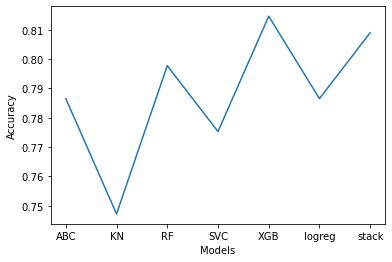

In [253]:
labels = list(score.keys())
value = list(score.values())
sns.lineplot(x=labels,y =value)
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks()
plt.show()

It looks like XGB classifier gave the best accuracy. We will use this as our final model.

In [171]:
stack = StackingClassifier(estimators = [('logreg',logreg),('kn',kn),('xgb',xgb_cls),
                                         ('svc',svc),('rf',rf),('abc',abc)],final_estimator = SVC(C = 80, kernel = 'rbf'), cv = 10, passthrough = False)
stack.fit(X,y)


In [172]:
final_submission = pd.DataFrame({'PassengerId': id, 'Survived': final})
final_submission.to_csv('final_submission.csv', index = False)
final_submission.head(5)

,PassengerId,Survived
888,892,0
889,893,1
890,894,0
891,895,0
892,896,1
